# Enhancing Stock Price Forecasting with Linear and Nonlinear Time Series Analysis


## Introduction
In this notebook, we will work through the complete process of performing linear and nonlinear time series analysis for the purpose of forecasting stock prices.
We will explore a number of techniques and models along the way whilst also making sure to explain our findings and the decisions that must be made at each step.

### Import dependencies

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import datetime

### Data import

Here we utilise the Pandas library to import time series data from Yahoo finance. We import daily close prices for three assets (NVDA, GSPC and TNX). We then calculate the log-return series for each asset and also resample to weekly and monthly frequency, resulting in three pairs of prices and log-returns at daily, weekly and monthly frequencies.

In [17]:
# Set start and end dates
start_date = datetime.datetime(2013, 4, 1)
end_date = datetime.datetime(2023, 4, 1)

In [18]:
# Define a dictionary with the ticker symbols and asset names
tickers = {
    "NVDA": "NVIDIA Corporation",
    "^GSPC": "S&P 500",
    "^TNX": "10-Year US Government Bond"
}

In [19]:
# Create an empty DataFrame to store the data
df_prices = pd.DataFrame()
df_returns = pd.DataFrame()

In [27]:
# Define the desired frequency (daily, weekly, monthly)
frequency = "1d"  # "1d" for daily, "1wk" for weekly, "1mo" for monthly

# Fetch the data from Yahoo Finance using yfinance for daily prices
df_daily_prices = yf.download(list(tickers.keys()), start=start_date, end=end_date, interval=frequency)["Close"]

# Calculate the log returns for daily prices
df_daily_log_returns = np.log(df_daily_prices / df_daily_prices.shift(1))

# Resample to weekly prices and calculate log returns
df_weekly_prices = df_daily_prices.resample("W").last()
df_weekly_log_returns = np.log(df_weekly_prices / df_weekly_prices.shift(1))

# Resample to monthly prices and calculate log returns
df_monthly_prices = df_daily_prices.resample("M").last()
df_monthly_log_returns = np.log(df_monthly_prices / df_monthly_prices.shift(1))

# Drop the first row
df_daily_prices = df_daily_prices.dropna()
df_daily_log_returns = df_daily_log_returns.dropna()
df_weekly_prices = df_weekly_prices.dropna()
df_weekly_log_returns = df_weekly_log_returns.dropna()
df_monthly_prices = df_monthly_prices.dropna()
df_monthly_log_returns = df_monthly_log_returns.dropna()

[*********************100%***********************]  3 of 3 completed


### Statistical analysis

#### Log return plot

Plot the monthly log return series for NVDA

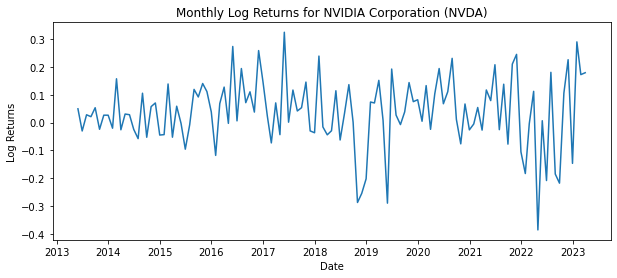

In [28]:
# Plot the log returns of NVDA
plt.figure(figsize=(10, 4))
plt.plot(df_monthly_log_returns.index, df_monthly_log_returns["NVDA"])
plt.title("Monthly Log Returns for NVIDIA Corporation (NVDA)")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.show()

#### ACF and PACF

Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)

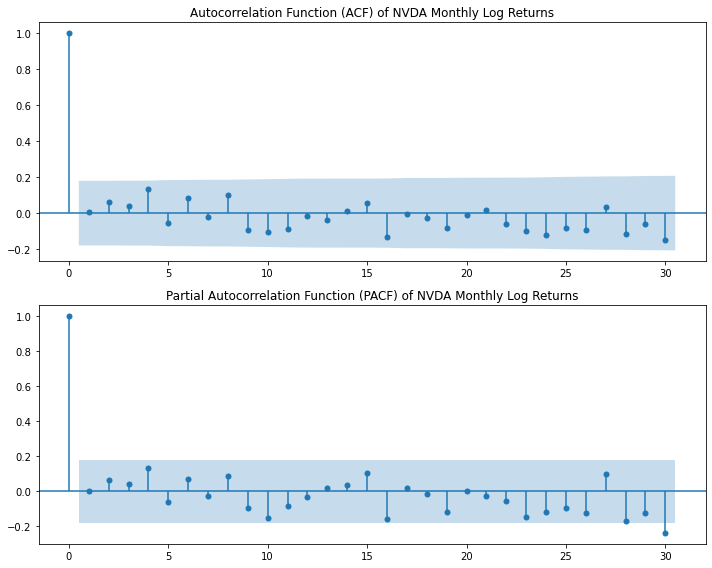

In [29]:
# Plot the ACF and PACF of NVDA log returns
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# ACF plot
plot_acf(df_monthly_log_returns["NVDA"], ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF) of NVDA Monthly Log Returns")

# PACF plot
plot_pacf(df_monthly_log_returns["NVDA"], ax=ax[1], lags=30)
ax[1].set_title("Partial Autocorrelation Function (PACF) of NVDA Monthly Log Returns")

plt.tight_layout()
plt.show()

#### Stationarity test

Perform Augmented Dickey-Fuller (ADF) test on the monthly log returns of NVDA to check for sationarity

In [30]:
# Perform the ADF test
adf_result = adfuller(df_monthly_log_returns["NVDA"])

# Extract the ADF test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Print the ADF test results
print("ADF Statistic: ", round(adf_statistic,3))
print("p-value: ", round(p_value,22))

ADF Statistic:  -10.666
p-value:  4.285e-19


The ADF Statistic value of -10.712 is a highly negative value. The more negative this statistic, the stronger the evidence against the null hypothesis of non-stationarity. In this case, the ADF Statistic suggests that there is evidence to reject the null hypothesis, indicating that the log returns of NVDA are likely stationary.

The p-value of 3.305e-19 is extremely small. Typically, if the p-value is below a chosen significance level (e.g., 0.05), we reject the null hypothesis. In this case, the very small p-value suggests strong evidence against the null hypothesis, reinforcing the conclusion that the log returns of NVDA are likely stationary.

These results indicate that the log returns of NVDA exhibit stationarity characteristics. Stationary time series are desirable for time series analysis as they have stable statistical properties over time, making them more amenable to modeling and forecasting.

#### Time series anonomaly detection

IQR method

In [31]:
# assuming df_monthly_log_returns is your DataFrame and "NVDA" is your column of interest
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]
    return outliers

outliers = detect_outliers_iqr(df_monthly_log_returns["NVDA"])
print(outliers)

Date
2018-10-31   -0.287374
2018-11-30   -0.254667
2019-05-31   -0.289821
2022-04-30   -0.386066
Name: NVDA, dtype: float64


Isolation forest method

In [32]:
def detect_outliers_isolation_forest(data):
    model = IsolationForest(contamination=0.01)
    model.fit(data.values.reshape(-1,1)) 
    data = pd.DataFrame(data)
    data['anomaly'] = model.predict(data.values.reshape(-1,1))
    outliers = data.loc[data['anomaly']==-1]
    return outliers

outliers = detect_outliers_isolation_forest(df_monthly_log_returns["NVDA"])
print(outliers)

                NVDA  anomaly
Date                         
2017-05-31  0.324970       -1
2022-04-30 -0.386066       -1


### Linear time series analysis

Let's start by splitting the data into a training set and a test set:

In [38]:
# Let's take the first 80% of data as training, and the rest as testing
split_point = int(len(df_monthly_log_returns["NVDA"]) * 0.8)
train = df_monthly_log_returns["NVDA"].iloc[:split_point]
test = df_monthly_log_returns["NVDA"].iloc[split_point:]

#### Linear regression

In [46]:
def linear_regression(train, test):
    X_train = np.array(range(len(train))).reshape(-1, 1)
    y_train = train.values

    model = LinearRegression()
    model.fit(X_train, y_train)

    X_test = np.array(range(len(train), len(train) + len(test))).reshape(-1, 1)
    predictions = model.predict(X_test)

    return predictions

lr_predictions = linear_regression(train, test)

#### ARIMA

In [64]:
def arima_model(train, test):
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()
    start = len(train)
    end = start + len(test) - 1
    # Forecast
    predictions = model_fit.get_prediction(start=start, end=end, dynamic=True).predicted_mean
    return predictions

arima_predictions = arima_model(train, test)

#### SARIMA

In [65]:
def sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(test))
    return predictions

sarima_predictions = sarima_model(train, test)

#### Analysis

Linear regression

Linear Regression MSE: 0.032054188891255046


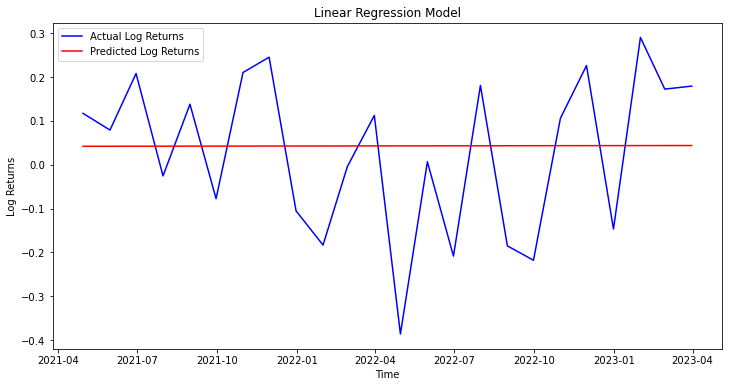

In [66]:
# Calculate and print MSE for Linear Regression
lr_mse = mean_squared_error(test, lr_predictions)
print(f"Linear Regression MSE: {lr_mse}")

# Plot the actual test data and Linear Regression predictions
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, color='blue', label='Actual Log Returns')
plt.plot(test.index, lr_predictions, color='red', label='Predicted Log Returns')
plt.title('Linear Regression Model')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

ARIMA

ARIMA MSE: 0.03277240424698119


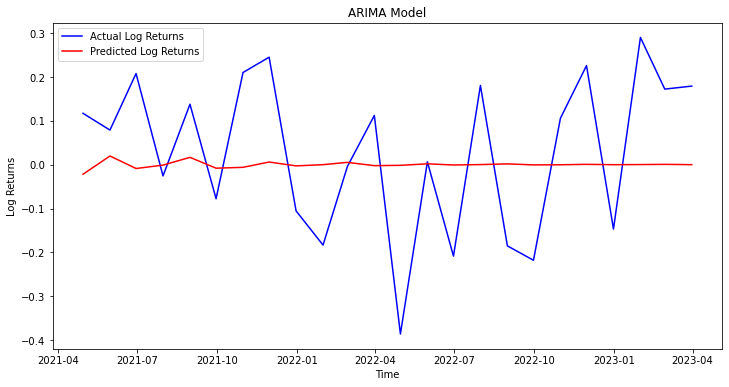

In [68]:
# Calculate and print MSE for ARIMA
arima_mse = mean_squared_error(test, arima_predictions)
print(f"ARIMA MSE: {arima_mse}")

# Plot the actual test data and ARIMA predictions
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, color='blue', label='Actual Log Returns')
plt.plot(test.index, arima_predictions, color='red', label='Predicted Log Returns')
plt.title('ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

SARIMA

SARIMA MSE: 0.038694999582032194


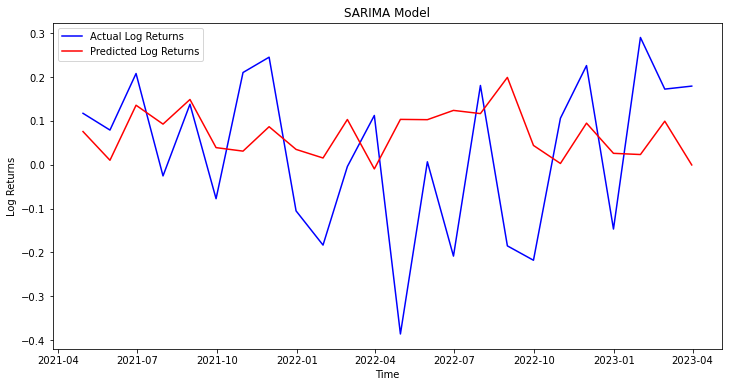

In [72]:
# Calculate and print MSE for SARIMA
sarima_mse = mean_squared_error(test, sarima_predictions)
print(f"SARIMA MSE: {sarima_mse}")

# Plot the actual test data and SARIMA predictions
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, color='blue', label='Actual Log Returns')
plt.plot(test.index, sarima_predictions, color='red', label='Predicted Log Returns')
plt.title('SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

Now lets see if we can improve our ARIMA model by optimising the parametes with respect to the Akaike information (AIC)

In [88]:
def optimize_arima_model(train, p_values, d_values, q_values):
    best_aic, best_order = float('inf'), None
    for order in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit(maxiter=2000)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic, best_order = aic, order
        except:
            continue
    return best_order, best_aic

def arima_model_optimized(train, test):
    p = d = q = range(0, 30)

    best_order, best_aic = optimize_arima_model(train, p, d, q)
    
    if best_order is not None:
        model = ARIMA(train, order=best_order)
        model_fit = model.fit(disp=0)
        start = len(train)
        end = start + len(test) - 1
        predictions = model_fit.get_prediction(start=start, end=end, dynamic=True).predicted_mean
    else:
        print('ARIMA model could not be optimized for the given data with p, d, q in range 0 to 30.')
        predictions = None
    
    return predictions

arima_predictions_optimized = arima_model_optimized(train, test)

ARIMA model could not be optimized for the given data with p, d, q in range 0 to 30.


With over 2000 iterations and all parameters (p,d,q) in the range 0 to 30, the ARIMA model is not able to be optimised. As a result, we will try a similar procedure with SARIMA instead

In [ ]:
def optimize_sarima_model(train, p_values, d_values, q_values, P_values, D_values, Q_values, m=12):
    best_aic, best_order, best_seasonal_order = float('inf'), None, None
    for order in itertools.product(p_values, d_values, q_values):
        for seasonal_order in itertools.product(P_values, D_values, Q_values):
            try:
                model = SARIMAX(train, order=order, seasonal_order=seasonal_order+(m,))
                model_fit = model.fit(maxiter=100)
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, order, seasonal_order
            except:
                continue
    return best_order, best_seasonal_order, best_aic

def sarima_model_optimized(train, test):
    p = d = q = P = D = Q = range(0, 3)  # This is just an example, you may need to adjust these ranges.
    m = 12  # monthly data, change this as per your data's seasonality

    best_order, best_seasonal_order, best_aic = optimize_sarima_model(train, p, d, q, P, D, Q, m)
    
    if best_order is not None and best_seasonal_order is not None:
        model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order+(m,))
        model_fit = model.fit()
        start = len(train)
        end = start + len(test) - 1
        predictions = model_fit.get_prediction(start=start, end=end, dynamic=True).predicted_mean
    else:
        print('SARIMA model could not be optimized for the given data with p, d, q, P, D, Q in range 0 to 15.')
        predictions = None
    
    return predictions

sarima_predictions_optimized = sarima_model_optimized(train, test)

In [ ]:
# Calculate and print MSE for SARIMA
sarima_mse_optimized = mean_squared_error(test, sarima_predictions_optimized)
print(f"Optimized SARIMA MSE: {sarima_mse_optimized}")

# Plot the actual test data and SARIMA predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarima_predictions_optimized, color='red', label='Optimized SARIMA forecast')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('NVDA Monthly Log Returns: Actual vs Optimized SARIMA Forecast')
plt.legend()
plt.show()
